In [1]:
import pandas as pd 
import numpy as np
import keras
import math 
import random 

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

2023-04-28 14:32:48.882157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 14:32:49.034557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-28 14:32:49.034575: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-28 14:32:49.793210: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
'''
Intro 
-----
In order to allow a model to learn as much as possible from a set of data, the important features of the data 
usually must be extracted and arranged in such a way that the model can use them to generalize relationships. 
Often there is a long discovery process, in which the data is interrogated manually in order to intuit what 
features to extract and how to present them. Training the model is usually one of the last steps in a lengthy
process. 

In this example I'm going to focus on price series data, for example a multi-year daily stock price time series, 
and I'm going to demonstrate an example of preprocessing the data to extract a few features, in order to prepare
the data to be used to train an LSTM model. 

This simplified example will consist of the following steps: 

1. Read the data 
2. Extract the daily range (high - low) 
3. Remove the trend 
4. Handle outliers 
5. Scale the data 
6. Extract data about the trend, as a new column 
7. Finally, shape the data into the correct shape to be used as input for a tensorflow LSTM model

Prerequisites: 
- python 3
- scikit-learn 
- pandas 
- jupyter notebook (or jupyter lab) 

The data comes from Yahoo Finance historical data, and is availbale at 

The data comes with the following columns: 
- Open
- High
- Low
- Close 
- Adjusted Close 
- Volume 

At the end of the example, the data will have been transformed, with 3 scaled and normalized columns: 
- Range
- Change
- Trend 

... and will be in the 3-dimensional array shape that a tensorflow LSTM model expects, split into 
training, evaluation, and testing sets. 
'''

"\nIntro \n-----\nIn order to allow a model to learn as much as possible from a set of data, the important features of the data \nusually must be extracted and arranged in such a way that the model can use them to generalize relationships. \nOften there is a long discovery process, in which the data is interrogated manually in order to intuit what \nfeatures to extract and how to present them. Training the model is usually one of the last steps in a lengthy\nprocess. \n\nIn this example I'm going to focus on price series data, for example a multi-year daily stock price time series, \nand I'm going to demonstrate an example of preprocessing the data to extract a few features, in order to prepare\nthe data to be used to train an LSTM model. \n\nThis simplified example will consist of the following steps: \n\n1. Read the data \n2. Extract the daily range (high - low) \n3. Remove the trend \n4. Handle outliers \n5. Scale the data \n6. Extract data about the trend, as a new column \n7. Fina

In [16]:
'''
The data is read from a file downloaded from the free historical stock data at Yahoo Finance; the columns 
are OHLC, plus Adjusted Close and Volume. Feel free to use any Yahoo historical stock price data, but the 
exact data file that I used is here: 

'''
df = pd.read_csv("data/prices-d.csv", index_col=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [17]:
'''
The only column that we won't be touching at all is Volume, so I'll just remove that straightaway. 
Also we don't need 'Close', as we'll use 'Adj Close' instead, as it's better for most purposes.
The other columns will be used to extract useful features, and then afterwards those source columns may be 
discarded from the DataFrame. 
'''
df.pop("Volume")
df.pop("Close")
df.head()

,Open,High,Low,Adj Close
Date,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667
2010-06-30,1.719333,2.028000,1.553333,1.588667
2010-07-01,1.666667,1.728000,1.351333,1.464000
2010-07-02,1.533333,1.540000,1.247333,1.280000
2010-07-06,1.333333,1.333333,1.055333,1.074000


In [18]:
# I. RANGE

In [19]:
'''
I.A: Capture the Range 

The absolute values of the Open, High, and Low won't be useful to us. The daily range as a percentage of 
something (the Open, or previous day's Close for example) could be useful though, so we should extract 
what's useful, and get rid of what's not. 
'''
df["Range"] = (df["High"] - df["Low"]) / df["Open"]
df.head()

,Open,High,Low,Adj Close,Range
Date,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,0.392632
2010-06-30,1.719333,2.028000,1.553333,1.588667,0.276076
2010-07-01,1.666667,1.728000,1.351333,1.464000,0.226000
2010-07-02,1.533333,1.540000,1.247333,1.280000,0.190870
2010-07-06,1.333333,1.333333,1.055333,1.074000,0.208500


In [20]:
'''
I.A.1: Alternative Way

The single line of code above that extracts the daily range is possible thanks to the non-native Python 
library pandas. In case you aren't 
accustomed to using pandas (and just to demonstrate what that line actually does) 
it would be as if I had looped through the data and done this: 
'''
df['Range'] = 0 #add new column 
for i in range(len(df)): 
    df['Range'][i] = (df["High"][i] - df["Low"][i]) / df["Open"][i]
df.head()

/tmp/ipykernel_12352/2687170687.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Range'][i] = (df["High"][i] - df["Low"][i]) / df["Open"][i]


,Open,High,Low,Adj Close,Range
Date,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,0.392632
2010-06-30,1.719333,2.028000,1.553333,1.588667,0.276076
2010-07-01,1.666667,1.728000,1.351333,1.464000,0.226000
2010-07-02,1.533333,1.540000,1.247333,1.280000,0.190870
2010-07-06,1.333333,1.333333,1.055333,1.074000,0.208500


<AxesSubplot:xlabel='Date'>

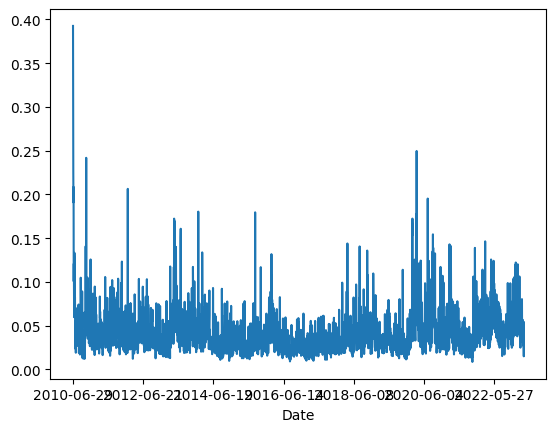

In [21]:
'''
I.B: Plotting the Data

Just to show what the Range column looks like, I will plot it. 
'''
df['Range'].plot()

In [22]:
'''
Just a few comments here; you can visually see a few things: 
- there is no discernable strong trend 
- the distribution is noticeably skewed right, with extreme positive outliers 
- the range of the data is not neatly between 0 and 1

The lack of trend is a good thing, we want that to feed into the model. The right-skew and the scale, we will 
fix in later steps. 
'''

'\nJust a few comments here; you can visually see a few things: \n- there is no discernable strong trend \n- the distribution is noticeably skewed right, with extreme positive outliers \n- the range of the data is not neatly between 0 and 1\n\nThe lack of trend is a good thing, we want that to feed into the model. The right-skew and the scale, we will \nfix in later steps. \n'

In [23]:
'''
If you like to get empirical, we can show the low trendiness of the series using augmented Dickey-Fuller or 
some other metric. 
'''
print('p-value: %f' % adfuller(df['Range'])[1])

p-value: 0.000000


<AxesSubplot:ylabel='Density'>

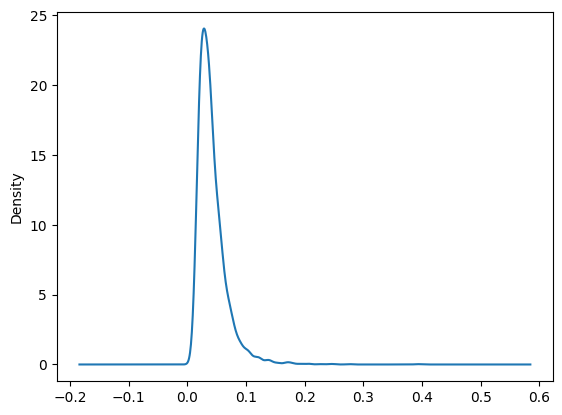

In [24]:
'''
I.C: Plot Distribution

Here I've plotted the distribution to better show the skewness of the data, though you can see it plainly 
enough in the previous plot. Removing outliers should make the data more balanced, so I will do that in a later 
step. 
'''
df['Range'].plot(kind='kde')

In [25]:
'''
I.D: Remove Extra Columns

Now that we've extracted the daily range from the Open, High, and Low columns, we don't need those anymore, 
so I'll just remove them. The information that we needed is now in the Range column. 
'''
# remove extra columns 
df.pop("Open")
df.pop("High")
df.pop("Low")
df.head()

,Adj Close,Range
Date,,
2010-06-29,1.592667,0.392632
2010-06-30,1.588667,0.276076
2010-07-01,1.464000,0.226000
2010-07-02,1.280000,0.190870
2010-07-06,1.074000,0.208500


In [26]:
# II. Detrending Price (Capture Change)

In [27]:
'''
II.A: Absolute Change 

A data series may have trend, and it may have seasonality. Multi-year stock price data is less likely to show 
seasonality, but very likely to show a strong persistent trend. The problem with trended data (especially 
financial asset data which tends to grow exponentially) is that it smashes early data into oblivion, making 
it nearly invisible to the model trying to generalize something from it. This is why absolute price is 
almost never fed into a model without being heavily processed.

Now for the closing price ('Adj Close' column), again no one cares about the absolute price from day to day, 
what one cares about is the change in price from day to day. Pandas lets us acheive that with the following 
single line: 
'''
df['Abs Change'] = df["Adj Close"].diff()
df.head()

,Adj Close,Range,Abs Change
Date,,,
2010-06-29,1.592667,0.392632,NaN
2010-06-30,1.588667,0.276076,-0.004000
2010-07-01,1.464000,0.226000,-0.124667
2010-07-02,1.280000,0.190870,-0.184000
2010-07-06,1.074000,0.208500,-0.206000


<AxesSubplot:xlabel='Date'>

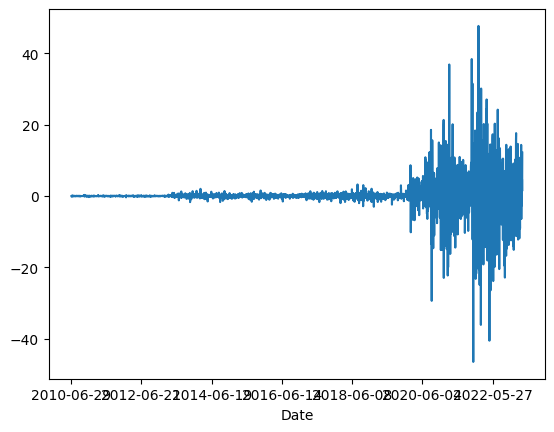

In [28]:
'''
II.A.1: Problem with Absolute Change

But the main problem is evident when we plot this over time. We can see that as the price rose over the years, the 
average daily change also increased, naturally. This is not ideal data to feed into a model, because 
(as you can see) earlier values will be de-emphasized to the point of nearly being ignored, whereas later 
data points will be overemphasized in relation. Since we would like the model to be able to glean meaningful 
data from the entire dataset, this is less than ideal. The plot below shows data that is likely to be 
difficult for a model to extract generalizations from. 
'''
df['Abs Change'].plot()

<AxesSubplot:xlabel='Date'>

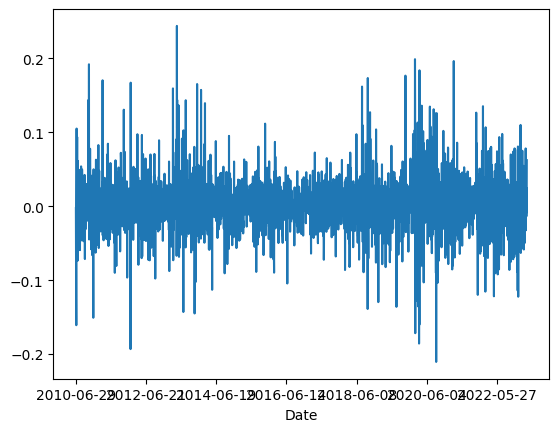

In [29]:
'''
II.B: Percentage Change

Instead, the percentage change is what we want. It's less likely to be skewed or trended, and we can see this visually
by plotting. 
'''
#first remove Abs Change, as we don't need it 
df.pop("Abs Change")

df['Change'] = df["Adj Close"].pct_change()
df['Change'].plot()

In [30]:
'''
II.B.1: NaN in first row 

Note that the very first value for the Pct Change column is a NaN. The reason is that to get this column, each 
value in the source column was compared to its previous timestep, and the first record has no previous to which 
to compare. 
'''
df.head()

,Adj Close,Range,Change
Date,,,
2010-06-29,1.592667,0.392632,NaN
2010-06-30,1.588667,0.276076,-0.002512
2010-07-01,1.464000,0.226000,-0.078473
2010-07-02,1.280000,0.190870,-0.125683
2010-07-06,1.074000,0.208500,-0.160937


In [31]:
'''
II.B.1.a: Remove the NaN

The NaN can be removed reasonably by either basing the first change off of the Open 
(instead of the previous step's Close), or just by simply removing the first row. I'll just remove the first row. 
'''
print('len before:', len(df))
df = df. tail(-1) 
print('len after:', len(df))
df.head()

len before: 3212
len after: 3211


,Adj Close,Range,Change
Date,,,
2010-06-30,1.588667,0.276076,-0.002512
2010-07-01,1.464000,0.226000,-0.078473
2010-07-02,1.280000,0.190870,-0.125683
2010-07-06,1.074000,0.208500,-0.160937
2010-07-07,1.053333,0.100610,-0.019243


In [32]:
# III. Outliers

In [33]:
'''
The model is best able to extract generalizations from the data if most of the data falls within a normal 
range. Outliers tend to skew the data such that some values (which may be important) will be almost ignored, 
whereas others will be overemphasized. 

Just to clarify I'm not talking here about outliers that may reflect mistakes in the data collection process 
necessarily (bad data samples can often just be discarded), but simply events of unusual magnitude. For 
example, price data that contains a swan event such as a major flash 
crash that is many times larger than the normal daily move may de-emphasize the magnitude of all of the others 
days' data. This can cause a model trained on data that contains the swan event to come up with very different results 
compared to the same model trained on data that did not contain the event. That's not ideal, because it 
indicates that something is interfering with the model's ability to generalize from the available data.
'''


"\nThe model is best able to extract generalizations from the data if most of the data falls within a normal \nrange. Outliers tend to skew the data such that some values (which may be important) will be almost ignored, \nwhereas others will be overemphasized. \n\nJust to clarify I'm not talking here about outliers that may reflect mistakes in the data collection process \nnecessarily (bad data samples can often just be discarded), but simply events of unusual magnitude. For \nexample, price data that contains a swan event such as a major flash \ncrash that is many times larger than the normal daily move may de-emphasize the magnitude of all of the others \ndays' data. This can cause a model trained on data that contains the swan event to come up with very different results \ncompared to the same model trained on data that did not contain the event. That's not ideal, because it \nindicates that something is interfering with the model's ability to generalize from the available data.\n"

In [34]:
# III.A: Outliers in Change Column

<AxesSubplot:xlabel='Date'>

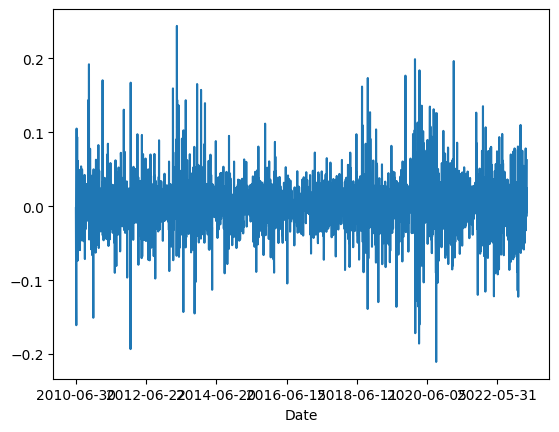

In [35]:
'''
III.A.1: Plot Change Before Handling Outliers

Take another peek at the Change column before handling outliers. Note that just by visual inspection, it's 
clear that most of the data falls into a very small percentage of the full range of values. That should be 
corrected so that at least more than 50% of the data falls within more than 50% of the range (just ballpark 
figures here, there is no real rule of thumb. It would depend on the goals of the data, and your idea of 
what the ideal 'balance' of data is for your situation; but we can see that the data here is clearly not 
well balanced). 
'''
df['Change'].plot()

In [36]:
'''
III.A.2: Function to Squash Outliers

I don't want to remove the rows that contain outliers, because that would be removing real data that we want 
to give to the model. I don't 
want to zero the values either as that would skew the data in a different direction. Instead I would like to 
'squash' the values to within a reasonable range, where outliers >=n will be treated the same as values 
that are equal to n.
'''
def squash_col_outliers(
    df: pd.DataFrame, 
    col_name: str, 
    min_quantile: float =0.01, 
    max_quantile:float =0.99
): 
    q_lo = df[col_name].quantile(min_quantile)
    q_hi  = df[col_name].quantile(max_quantile)
    
    df.loc[df[col_name] >= q_hi, col_name] = q_hi
    df.loc[df[col_name] <= q_lo, col_name] = q_lo
    return df

'''
Min and Max before squashing:
'''
print('MIN:', df['Change'].min())
print('MAX:', df['Change'].max())

MIN: -0.2106282385165198
MAX: 0.24395072987549127


In [25]:
'''
III.A.3: Squash Outliers in Change
'''
df = squash_col_outliers(df, 'Change')

'''
Min and Max after squashing:
'''
print(df['Change'].max())
print(df['Change'].min())

0.10999024964609014
-0.09005126578365338


<AxesSubplot:xlabel='Date'>

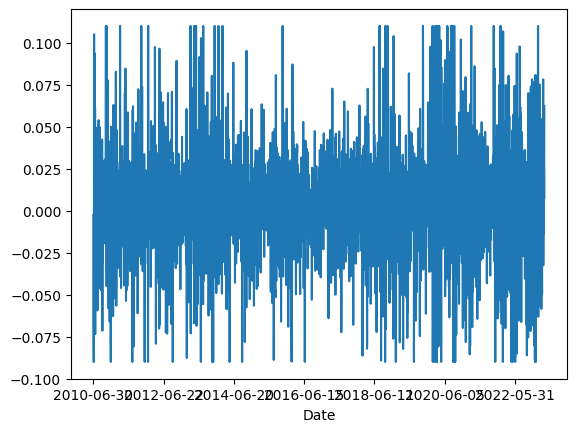

In [26]:
'''
III.A.4: Plot Change After Handling Outliers

Now we can visually see in the plot of Change that there's a more balanced distribution of values, that will be 
more healthy for the model to digest. Again, there is no formula for the perfect balance, and this is part 
of a discovery process in which we'd like to get enough information to intuit a good enough rule, or what is 
closer to an ideal. 
'''
df['Change'].plot()

In [27]:
# III.B Outliers in Range Column

<AxesSubplot:xlabel='Date'>

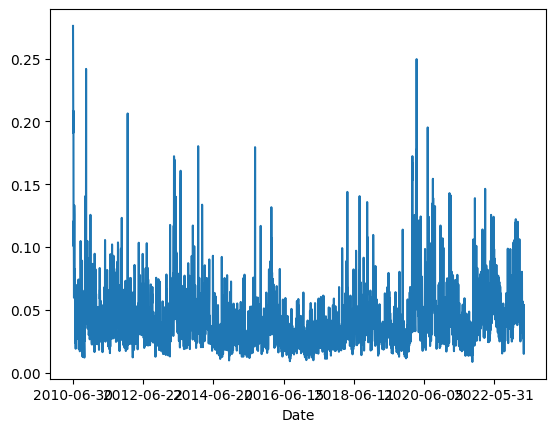

In [28]:
'''
III.B.1: Plot Range Before Handling Outliers

The shape of the Range data is a bit different, so I'm going to do basically the same thing, but I'm going 
to pass different values for the upper and lower limits, so that the left of the distribution will be less 
affected by squashing, and the right of the distribution will be more affected (which is where it's needed). 
I can do that by just passing lower values (lower than the default) for both min_quantile and max_quantile. 
That will cause the function to squash more on the top and less (or not at all, in this case) on the bottom. 
'''
df['Range'].plot()

<AxesSubplot:xlabel='Date'>

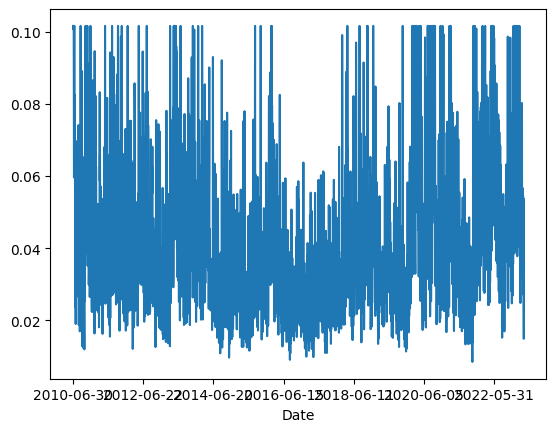

In [29]:
'''
III.B.2: Squash Outliers in Range
'''
df = squash_col_outliers(df, 'Range', min_quantile=0.0, max_quantile=0.97)

'''
And now, we likewise see a more favorable distribution of values. 
'''
df['Range'].plot()

In [30]:
df.head()

,Adj Close,Range,Change
Date,,,
2010-06-30,1.588667,0.101623,-0.002512
2010-07-01,1.464000,0.101623,-0.078473
2010-07-02,1.280000,0.101623,-0.090051
2010-07-06,1.074000,0.101623,-0.090051
2010-07-07,1.053333,0.100610,-0.019243


In [37]:
# IV: Scaling the Data

In [38]:
'''
Scaling input data between 0 and 1 is conventional when preparing inputs to LSTM or other types of 
models. While not strictly necessary, and there are cases when it's not advised, it is considered good 
practice. 
'''

"\nScaling input data between 0 and 1 is conventional when preparing inputs to LSTM or other types of \nmodels. While not strictly necessary, and there are cases when it's not advised, it is considered good \npractice. \n"

In [39]:
'''
IV.A The Scaling Function 

This function uses MinMaxScaler from scikitlearn package to fit the values of a given column between 0 and 1 
(or any given values) and replaces the original column in the DataFrame with the new data. 
'''

def scale_col_values(
    df: pd.DataFrame, 
    col_name:str, 
    min_value:float=0, 
    max_value:float=1
): 
    values = df[col_name].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(min_value, max_value))
    scaled_values = scaler.fit_transform(values)
    df[col_name] = scaled_values.transpose()[0]
    return df

In [40]:
'''
Check the min and max of the Change column before scaling. 
'''
print(df['Change'].min())
print(df['Change'].max())

-0.2106282385165198
0.24395072987549127


In [35]:
df = scale_col_values(df, 'Change')

In [36]:
'''
Check that it's been changed by the scaling process. 
'''
print(df['Change'].min())
print(df['Change'].max())

0.0
0.9999999999999999


<AxesSubplot:xlabel='Date'>

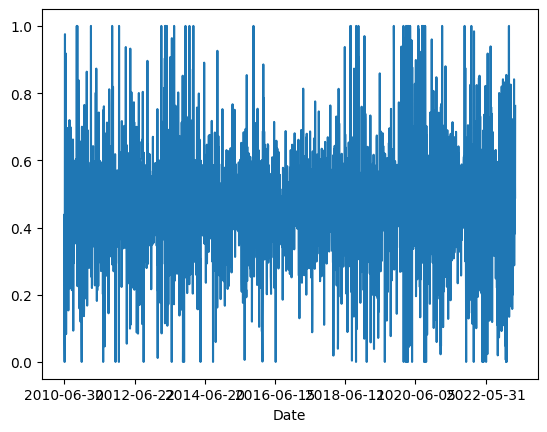

In [37]:
'''
And very importantly, note that the shape of the data has not changed, it's only been rescaled. The plot 
from before looks the same as after, except for the scale of the y axis. 
'''
df['Change'].plot()

In [38]:
'''
Scaling of Range is exactly the same. 
'''
df = scale_col_values(df, 'Range')

<AxesSubplot:xlabel='Date'>

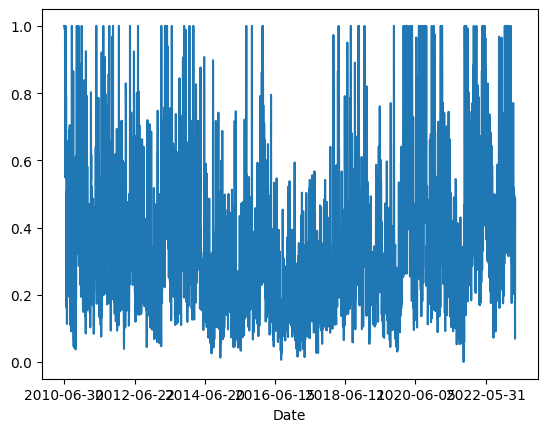

In [39]:
'''
And likewise, the scale has been the only thing changed. 
'''
df['Range'].plot()